In [1]:
# импортирование необходимых библиотек
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import seaborn as sns
from scipy.signal import savgol_filter
import tensorflow as tf
from sklearn.preprocessing import  StandardScaler
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import r2_score
import math


import functions
import random
import functools

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18280218506799199942
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1436408219
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9602110102636286394
physical_device_desc: "device: 0, name: GeForce 940MX, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


# Загрузка и подготовка данных

In [3]:
# загрузка данных
data1 = pd.read_csv('USROP_A 2 N-SH_F-14d.csv')
data2 = pd.read_csv('USROP_A 3 N-SH-F-15d.csv')
data3 = pd.read_csv('USROP_A 4 N-SH_F-15Sd.csv')
data4 = pd.read_csv('USROP_A 1 N-S_F-7d.csv')


In [4]:
data1 = data1.drop(['Unnamed: 0'],axis=1)
data2 = data2.drop(['Unnamed: 0'],axis=1)
data3= data3.drop(['Unnamed: 0'],axis=1)
data4 = data4.drop(['Unnamed: 0'],axis=1)

In [5]:
# описание загруженного набора данных
data1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47645 entries, 0 to 47644
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Measured Depth m                47645 non-null  float64
 1   Weight on Bit kkgf              47645 non-null  float64
 2   Average Standpipe Pressure kPa  47645 non-null  float64
 3   Average Surface Torque kN.m     47645 non-null  float64
 4   Rate of Penetration m/h         47645 non-null  float64
 5   Average Rotary Speed rpm        47645 non-null  float64
 6   Mud Flow In L/min               47645 non-null  float64
 7   Mud Density In g/cm3            47645 non-null  float64
 8   Diameter mm                     47645 non-null  float64
 9   Average Hookload kkgf           47645 non-null  float64
 10  Hole Depth (TVD) m              47645 non-null  float64
 11  USROP Gamma gAPI                47645 non-null  float64
dtypes: float64(12)
memory usage: 4.4

In [6]:
def data_preproccesing(data):
         # Очистка пропущенных данных в столбце глубины
        data_1=data
        #data_1 = data.dropna(axis=0,subset=['Measured Depth m'])
        
        # очистка данных от выбросов путем разработки модели изоляционного леса
        clf=IsolationForest(n_estimators=200, max_samples='auto', contamination=float(.08), \
                        max_features=5, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
        clf.fit(data_1)
        pred = clf.predict(data_1)
        data_1['anomaly']=pred
        outliers=data_1.loc[data_1['anomaly']==-1]
        outlier_index=list(outliers.index)
        
        # Найти количество найденных аномалий  
        print(data_1['anomaly'].value_counts())
        data_1 = data_1[data_1['anomaly']==1]
        data_1 = data_1.drop(['anomaly'],axis=1)
         
        
     # Заполнение пропущенных данных
        data_1['Weight on Bit kkgf'] = data['Weight on Bit kkgf'].fillna(data['Weight on Bit kkgf'].median())
        data_1['Average Hookload kkgf'] = data['Average Hookload kkgf'].fillna(data['Average Hookload kkgf'].median())
        data_1['Average Rotary Speed rpm'] = data['Average Rotary Speed rpm'].fillna(data['Average Rotary Speed rpm'].median())
        data_1['Average Standpipe Pressure kPa'] = data['Average Standpipe Pressure kPa'].fillna(data['Average Standpipe Pressure kPa'].median())
        data_1['Average Surface Torque kN.m'] = data['Average Surface Torque kN.m'].fillna(data['Average Surface Torque kN.m'].median())
        data_1['Mud Density In g/cm3'] = data['Mud Density In g/cm3'].fillna(data['Mud Density In g/cm3'].median())
        data_1['Rate of Penetration m/h'] = data['Rate of Penetration m/h'].fillna(data['Rate of Penetration m/h'].median())
        data_1['Mud Flow In L/min'] = data['Mud Flow In L/min'].fillna(data['Mud Flow In L/min'].median())
        data_1['USROP Gamma gAPI'] = data['USROP Gamma gAPI'].fillna(data['USROP Gamma gAPI'].median())
        
        
       
        
        return data_1
data_1 = data_preproccesing(data1)
data_2 = data_preproccesing(data2)
data_3 = data_preproccesing(data3)
data_4 = data_preproccesing(data4)

 1    43835
-1     3810
Name: anomaly, dtype: int64
 1    48798
-1     4243
Name: anomaly, dtype: int64
 1    47572
-1     4136
Name: anomaly, dtype: int64
 1    5878
-1     511
Name: anomaly, dtype: int64


In [7]:
data_1.describe()

,Measured Depth m,Weight on Bit kkgf,Average Standpipe Pressure kPa,Average Surface Torque kN.m,Rate of Penetration m/h,Average Rotary Speed rpm,Mud Flow In L/min,Mud Density In g/cm3,Diameter mm,Average Hookload kkgf,Hole Depth (TVD) m,USROP Gamma gAPI
count,43835.000000,43835.000000,43835.000000,43835.000000,43835.000000,43835.000000,43835.000000,43835.000000,43835.000000,43835.000000,43835.000000,43835.000000
mean,2328.497634,5.760103,17450.890608,11.323162,25.309119,140.731520,3203.851853,1.303881,338.071624,133.649011,2242.698871,65.635773
std,711.573148,2.667289,2728.033218,2.517192,12.848110,32.358949,1054.431372,0.051563,108.216261,12.472986,611.344477,33.690151
min,1088.035000,0.785182,10198.999786,4.980001,1.160000,0.000000,1674.739990,1.180000,215.900000,103.134097,1087.546212,0.000000
25%,1696.965000,4.201231,16074.000550,9.660000,14.210000,120.059998,1985.010009,1.270000,215.900000,130.472686,1696.475042,39.131000
50%,2299.615000,5.384102,17489.999387,11.390000,24.780001,159.449997,3524.459960,1.310000,311.150000,138.375487,2297.845442,63.510000
75%,2961.613500,6.638353,18283.999637,12.829999,35.230000,160.369995,4162.660156,1.350000,444.500000,140.200788,2842.925683,94.433000
max,3466.033000,15.091800,24557.000735,26.550000,56.070000,181.550003,4538.450195,1.380000,444.500000,152.926842,2993.804426,208.664000


In [8]:
# Статистический анализ выбранных параметров
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df = data_1.describe()
df

,Measured Depth m,Weight on Bit kkgf,Average Standpipe Pressure kPa,Average Surface Torque kN.m,Rate of Penetration m/h,Average Rotary Speed rpm,Mud Flow In L/min,Mud Density In g/cm3,Diameter mm,Average Hookload kkgf,Hole Depth (TVD) m,USROP Gamma gAPI
count,43835.00,43835.00,43835.00,43835.00,43835.00,43835.00,43835.00,43835.00,43835.00,43835.00,43835.00,43835.00
mean,2328.50,5.76,17450.89,11.32,25.31,140.73,3203.85,1.30,338.07,133.65,2242.70,65.64
std,711.57,2.67,2728.03,2.52,12.85,32.36,1054.43,0.05,108.22,12.47,611.34,33.69
min,1088.04,0.79,10199.00,4.98,1.16,0.00,1674.74,1.18,215.90,103.13,1087.55,0.00
25%,1696.96,4.20,16074.00,9.66,14.21,120.06,1985.01,1.27,215.90,130.47,1696.48,39.13
50%,2299.61,5.38,17490.00,11.39,24.78,159.45,3524.46,1.31,311.15,138.38,2297.85,63.51
75%,2961.61,6.64,18284.00,12.83,35.23,160.37,4162.66,1.35,444.50,140.20,2842.93,94.43
max,3466.03,15.09,24557.00,26.55,56.07,181.55,4538.45,1.38,444.50,152.93,2993.80,208.66


In [93]:
# Cглаживание тестовых данных
def data_smoothing(data): 
    data['Rate of Penetration m/h'] = savgol_filter(data['Rate of Penetration m/h'].values,89,3)
    data['Average Hookload kkgf'] = savgol_filter(data['Average Hookload kkgf'].values,101,3)
    data['Weight on Bit kkgf'] = savgol_filter(data['Weight on Bit kkgf'].values,101,3)
    data['Average Rotary Speed rpm'] = savgol_filter(data['Average Rotary Speed rpm'].values,101,3)
    data['USROP Gamma gAPI'] = savgol_filter(data['USROP Gamma gAPI'].values,101,3)
    data['Average Standpipe Pressure kPa'] = savgol_filter(data['Average Standpipe Pressure kPa'].values,101,3)
    data['Average Surface Torque kN.m'] = savgol_filter(data['Average Surface Torque kN.m'].values,101,3)
    return data
data_1 = data_smoothing(data_1)
data_2 = data_smoothing(data_2)
data_3 = data_smoothing(data_3)
data_4 = data_smoothing(data_4)

# Визуализация данных

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


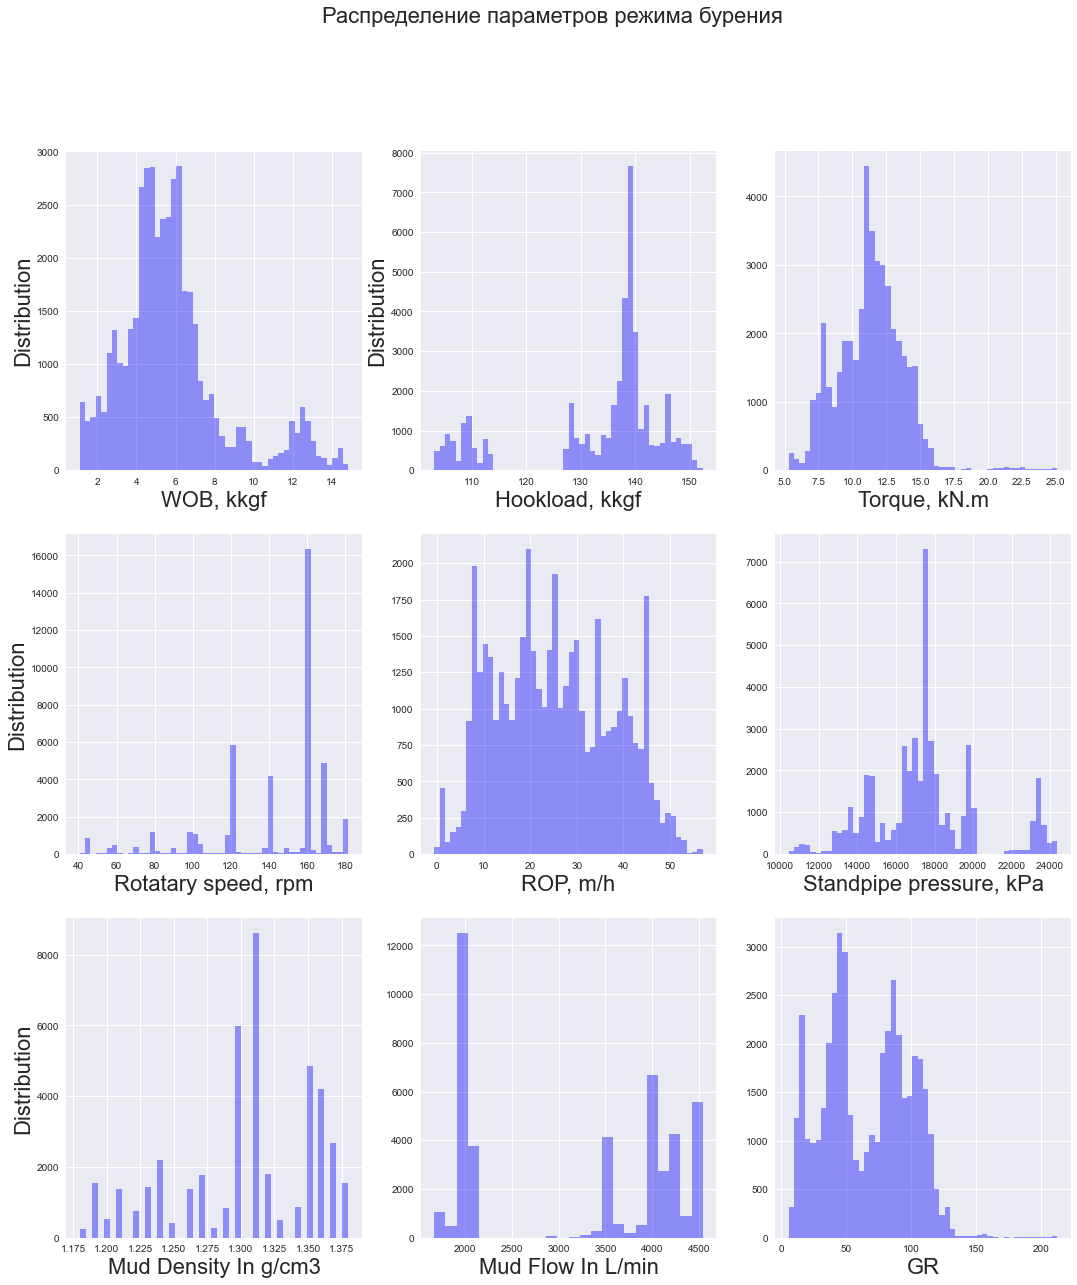

In [94]:
functions.data_distribution_plot(data=data_1)

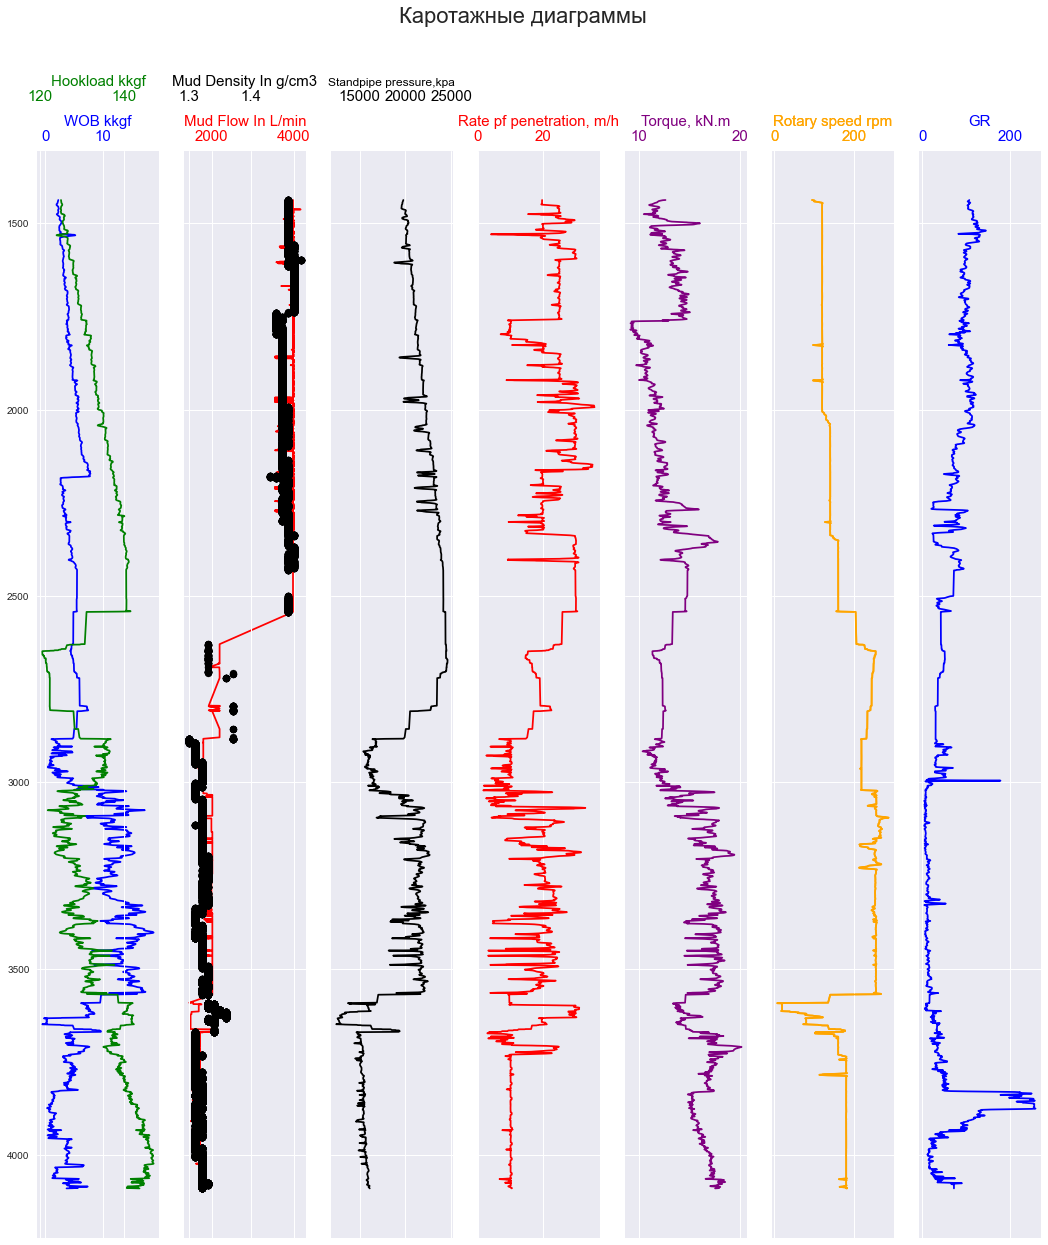

In [95]:
functions.log_plot(data_3)

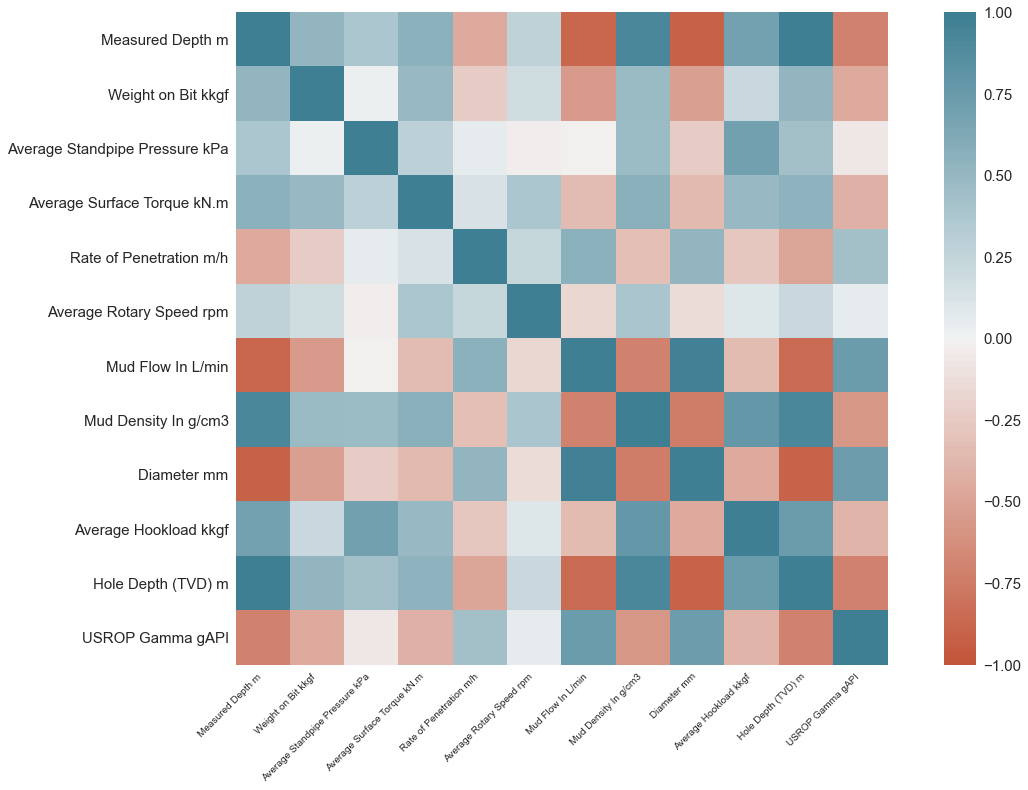

In [12]:
#data_1 = data_1.drop(labels='anomaly',axis=1)
functions.CorrMatrix(data_1)

# Построение регрессионной модели машинного обучения

## Регресионная модель на основе LSTM

In [13]:
# Выбор признаков для обучения 1 скважина
y_tr1 = np.array(data_1['Rate of Penetration m/h'])
#data_1_train = data_1.drop(data_1[['anomaly']],axis=1)
x_tr1 = np.array(data_1)

# Выбор признаков для обучения 2 скважина
y_tr2 = np.array(data_2['Rate of Penetration m/h'])
#data_2_train = data_2.drop(data_2[['anomaly']],axis=1)
x_tr2 = np.array(data_2)

# Выбор признаков для обучения 3 скважина
y_tr3 = np.array(data_3['Rate of Penetration m/h'])
#data_3_train = data_3.drop(data_3[['anomaly']],axis=1)
x_tr3 = np.array(data_3)

# Выбор признаков для обучения 4 скважина
y_tr4 = np.array(data_4['Rate of Penetration m/h'])
#data_4_train = data_4.drop(data_4[['anomaly']],axis=1)
x_tr4 = np.array(data_4)

In [22]:
# Шкалирование данных
def data_encoding(x_tr,y_tr):
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    x_scaled = scaler_x.fit_transform(x_tr)
    y_scaled = scaler_y.fit_transform(y_tr.reshape(-1,1))
    return x_scaled,y_scaled,scaler_x,scaler_y
x_tr1,y_tr1,scaler_x1,scaler_y1 = data_encoding(x_tr1,y_tr1)
x_tr2,y_tr2,scaler_x2,scaler_y2 = data_encoding(x_tr2,y_tr2)
x_tr3,y_tr3,scaler_x3,scaler_y3 = data_encoding(x_tr3,y_tr3)
x_tr4,y_tr4,scaler_x4,scaler_y4 = data_encoding(x_tr4,y_tr4)

In [23]:
# Преобразование данных для обучения нейронной сети

def transform_data_multiple_features(x,y,n_future,n_past):
    
    X_train = []
    y_train = []

    #n_future          Окно прогноза 
   # n_past        Окно просмотра предыдущих записей

    for i in range(n_past, len(x) - n_future+1):
        
        X_train.append(x[i - n_past:i, 0:x.shape[1]])
        y_train.append(y[i + n_future - 1:i + n_future, ])

    X_train, y_train = np.array(X_train), np.array(y_train)

    print('X_train shape == {}.'.format(X_train.shape))
    print('y_train shape == {}.'.format(y_train.shape))
    
    return X_train,y_train

In [24]:
# трансформирование данных
x_train1,y_train1  = transform_data_multiple_features(x_tr1,y_tr1,10,50)
x_train2,y_train2  = transform_data_multiple_features(x_tr2,y_tr2,10,50)
x_train3,y_train3  = transform_data_multiple_features(x_tr3,y_tr3,10,50)
x_train4,y_train4  = transform_data_multiple_features(x_tr4,y_tr4,10,50)

X_train shape == (43776, 50, 12).
y_train shape == (43776, 1, 1).
X_train shape == (48739, 50, 12).
y_train shape == (48739, 1, 1).
X_train shape == (47513, 50, 12).
y_train shape == (47513, 1, 1).
X_train shape == (5819, 50, 12).
y_train shape == (5819, 1, 1).


In [25]:
# Построение архитектуры нейронной сети
def model_builder():
    model = tf.keras.models.Sequential()
    
    
    model.add(tf.keras.layers.LSTM(64,return_sequences=True, input_shape=(x_train1.shape[1], x_train1.shape[2])))
    #model.add(tf.keras.layers.LSTM(128, return_sequences=False,stateful=True))
    model.add(tf.keras.layers.LSTM(128, return_sequences=True))
    model.add(tf.keras.layers.LSTM(256, return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.LSTM(128, return_sequences=True))
    model.add(tf.keras.layers.LSTM(64, return_sequences=False))
    model.add(tf.keras.layers.Dense(units=1))
    
    model.compile(loss='mse', optimizer=optimizers.Adam(),metrics="RootMeanSquaredError")
    return model

In [18]:
model = model_builder()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 64)            19712     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 128)           98816     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 256)           394240    
_________________________________________________________________
dropout (Dropout)            (None, 50, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 128)           197120    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 1)                 6

In [771]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

In [772]:
# тренировка модели
with tf.device(tf.DeviceSpec(device_type="CPU", device_index=0)):
    
    history1 = model.fit(x_train1, y_train1,
          epochs=1,batch_size=10,callbacks=[callback],verbose =1)
    history2 = model.fit(x_train2, y_train2,
          epochs=1,batch_size=10,callbacks=[callback],verbose =1)
    history3 = model.fit(x_train3, y_train3,
          epochs=1,batch_size=10,callbacks=[callback],verbose =1)
    history4 = model.fit(x_train4, y_train4,
          epochs=1,batch_size=10,callbacks=[callback],verbose =1)

582/582 [==============================] - 182s 312ms/step - loss: 0.0124 - root_mean_squared_error: 0.1112


In [773]:
model.save('LSTM_10_50.h5')

In [69]:
from tensorflow import keras
model = keras.models.load_model('LSTM_10_50.h5')

In [70]:
#model = keras.models.load_model('LS')

## Тестирование

In [71]:
# тестирование модели
test = pd.read_csv('USROP_A 0 N-NA_F-9_Ad.csv')

def test_preprocces_for_LSTM(data):
    test = data_smoothing(data)
    y_test = np.array(test['Rate of Penetration m/h'])
    test_1 = test.drop(['Unnamed: 0'],axis=1)
    x_test = np.array(test_1)
    x_test_sc,y_test_sc,scaler_x,scaler_y = data_encoding(x_test,y_test)
    x_test,y_test = transform_data_multiple_features(x_test_sc,y_test_sc,10,50)
    return x_test,y_test,scaler_x,scaler_y
test = data_preproccesing(test)

 1    12648
-1     1098
Name: anomaly, dtype: int64


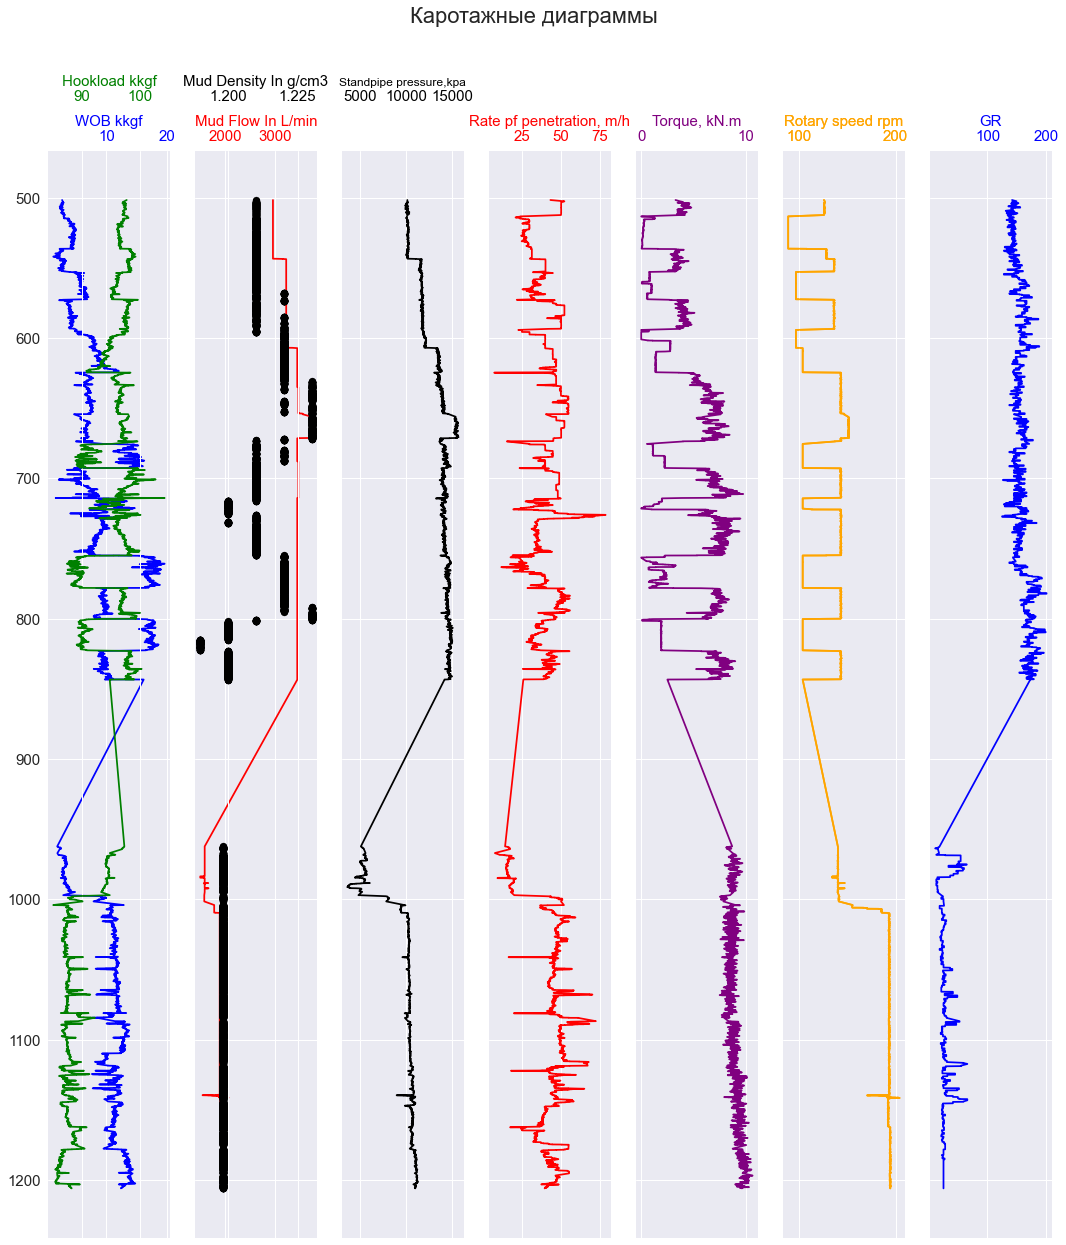

In [72]:
functions.log_plot(test)

In [73]:
x_test,y_test,scaler_x,scaler_y = test_preprocces_for_LSTM(test)

X_train shape == (12589, 50, 12).
y_train shape == (12589, 1, 1).


In [74]:
with tf.device(tf.DeviceSpec(device_type="CPU")):
    prediction = model.predict(x_test)

In [75]:
predictions = scaler_y.inverse_transform(prediction)

In [76]:
b = predictions[:,]

In [77]:
b.shape[0]

12589

In [88]:
a = np.array(test['Rate of Penetration m/h'][59:,].values)
a

array([50.08191325, 50.08320342, 50.08403163, ..., 39.56996565,
       39.44921838, 39.32271095])

In [89]:
a.shape[0]

12589

In [90]:
data = pd.DataFrame(data=a,columns=['Actual values'])
data['Predicted values'] = b[:,]

C:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


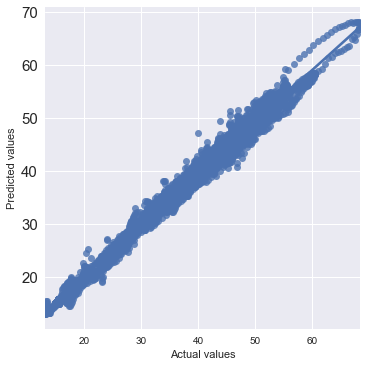

In [81]:
sns.lmplot('Actual values','Predicted values',data)

In [68]:
rmse = np.sqrt(np.mean(b-a)**2)
round(rmse,2)

0.28

In [46]:
round(r2_score(a,b),2)

0.98

In [48]:
data['Delta'] = abs((data['Actual values'] - data['Predicted values'])/data['Actual values'])
data['Delta'].describe()

count   12589.00
mean        0.03
std         0.03
min         0.00
25%         0.01
50%         0.02
75%         0.03
max         0.26
Name: Delta, dtype: float64

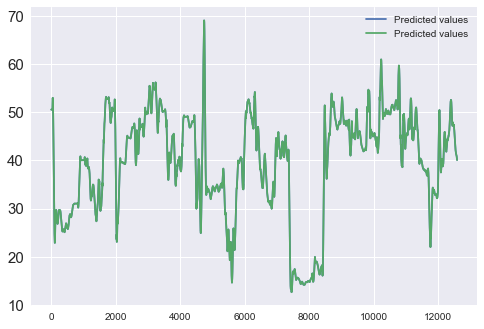

In [50]:
plt.plot(data['Predicted values'],label='Predicted values')
plt.plot(data['Predicted values'],label='Predicted values')
plt.legend()

## Тестирование на другой скважине

In [789]:
# тестирование модели
test = pd.read_csv('USROP_A 5 N-SH-F-5d.csv')


test = data_preproccesing(test)  

 1    17067
-1     1481
Name: anomaly, dtype: int64


In [790]:
test

,Unnamed: 0,Measured Depth m,Weight on Bit kkgf,Average Standpipe Pressure kPa,Average Surface Torque kN.m,Rate of Penetration m/h,Average Rotary Speed rpm,Mud Flow In L/min,Mud Density In g/cm3,Diameter mm,Average Hookload kkgf,Hole Depth (TVD) m,USROP Gamma gAPI
904,904,2905.00,0.01,14219.00,15.03,17.72,39.97,1599.13,1.29,215.90,133.24,2595.72,9.16
905,905,2905.02,0.01,14219.00,15.03,17.72,39.97,1599.13,1.29,215.90,133.24,2594.96,9.16
910,910,2905.20,0.01,14219.00,15.03,17.72,39.97,1599.13,1.29,215.90,133.24,2595.12,12.76
911,911,2905.23,0.01,14219.00,15.03,17.72,39.97,1599.13,1.29,215.90,133.24,2595.14,12.76
912,912,2905.28,0.01,14219.00,15.03,17.72,39.97,1599.13,1.29,215.90,133.24,2595.19,12.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18543,18543,3792.10,5.29,21008.00,24.66,7.68,129.95,2088.93,1.46,215.90,145.73,3246.48,56.64
18544,18544,3792.11,5.29,21008.00,24.66,7.68,129.95,2088.93,1.46,215.90,145.73,3246.49,56.64
18545,18545,3792.15,5.29,21008.00,24.66,7.68,129.95,2088.93,1.46,215.90,145.73,3246.51,56.64
18546,18546,3792.17,5.29,21008.00,24.66,7.68,129.95,2088.93,1.46,215.90,145.73,3246.52,56.64


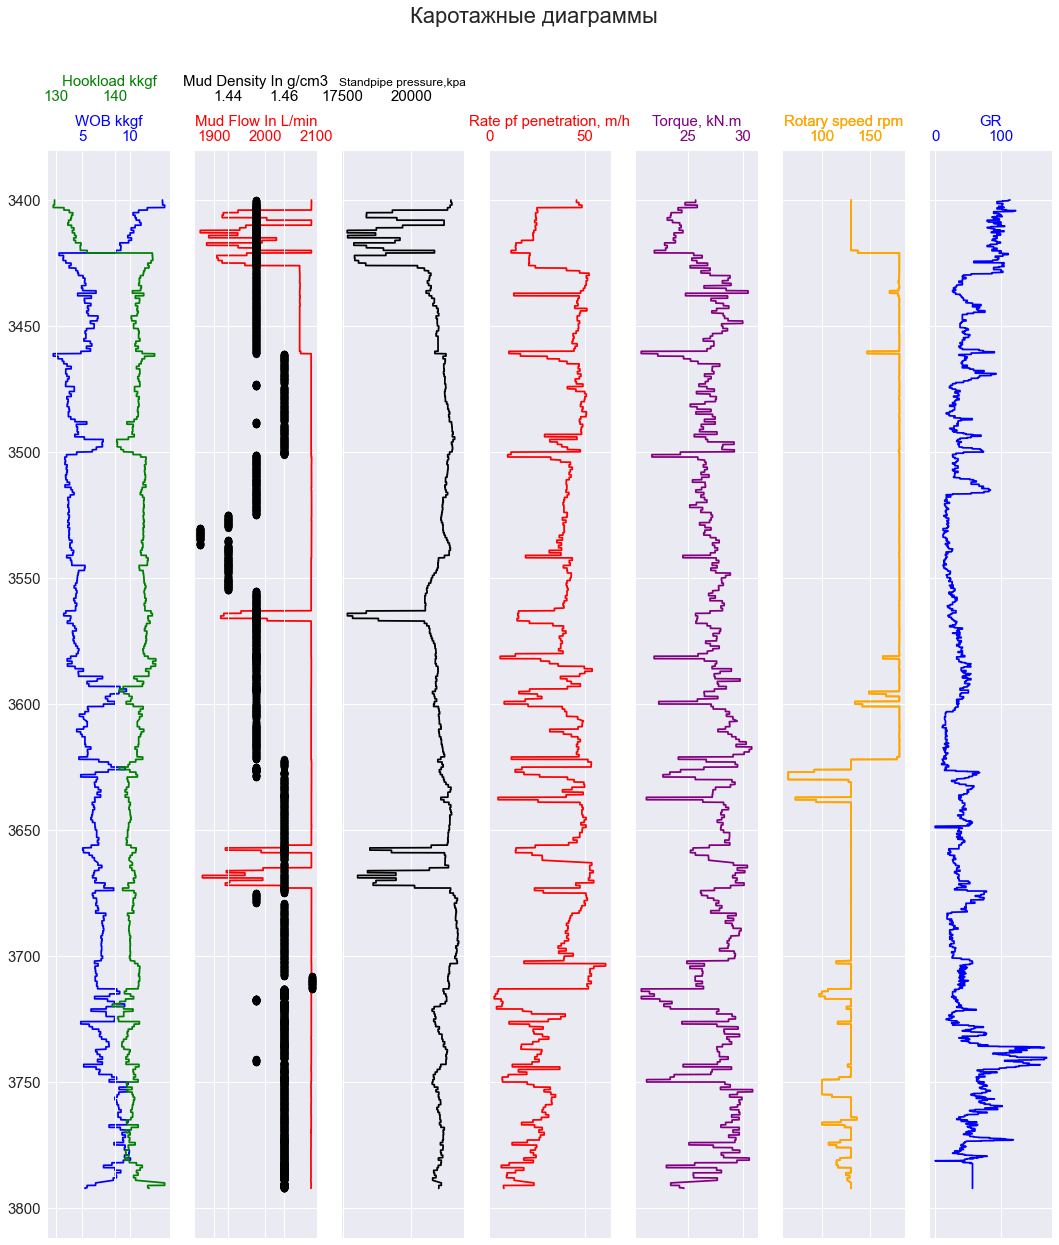

In [791]:
functions.log_plot(test.loc[(test['Measured Depth m'] > 3400) & (test['Measured Depth m'] < 3800)])

In [792]:
x_test,y_test,scaler_x,scaler_y = test_preprocces_for_LSTM(test)

X_train shape == (17008, 50, 12).
y_train shape == (17008, 1, 1).


In [793]:
with tf.device(tf.DeviceSpec(device_type="CPU")):
    prediction = model.predict(x_test)

In [794]:
predictions = scaler_y.inverse_transform(prediction)

In [795]:
b = predictions[:,]
a = np.array(test['Rate of Penetration m/h'][59:,].values)
a

array([ 6.07389144,  6.04429916,  6.03564241, ...,  9.59176256,
       10.01001293, 10.45224005])

In [796]:
rmse = np.sqrt(np.mean(b-a)**2)
round(rmse,2)

0.46

In [797]:
round(r2_score(a,b),2)

0.99

In [798]:
data = pd.DataFrame(data=a,columns=['Реальные значения'])
data['Прогнозные'] = b[:,]
data['Глубина'] = test['Measured Depth m']

C:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


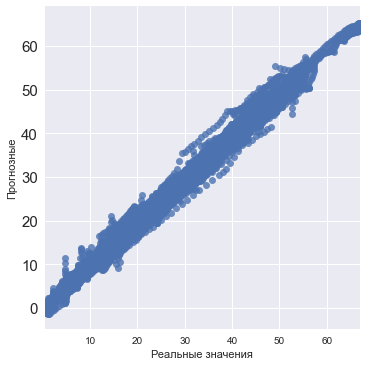

In [799]:
sns.lmplot('Реальные значения','Прогнозные',data)

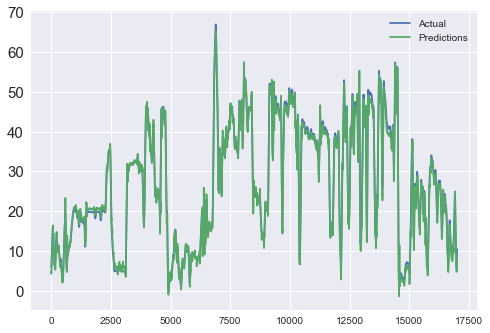

In [800]:
plt.plot(a,label='Actual')
plt.plot(b,label='Predictions')
plt.legend()

In [801]:
data['Delta'] = abs((data['Реальные значения'] - data['Прогнозные'])/data['Реальные значения'])
data['Delta'].describe()

count   17008.00
mean        0.06
std         0.11
min         0.00
25%         0.02
50%         0.03
75%         0.06
max         3.21
Name: Delta, dtype: float64

# Определение аномалий

In [802]:
data

,Реальные значения,Прогнозные,Глубина,Delta
0,6.07,4.71,nan,0.22
1,6.04,4.52,nan,0.25
2,6.04,4.36,nan,0.28
3,6.05,4.29,nan,0.29
4,6.08,4.29,nan,0.29
...,...,...,...,...
17003,8.83,7.00,3736.52,0.21
17004,9.20,7.30,3736.54,0.21
17005,9.59,7.62,3736.56,0.21
17006,10.01,7.95,3736.59,0.21


In [803]:
def detect_classify_anomalies(data,threshold):
    data['Delta'] = abs((data['Реальные значения'] - data['Прогнозные'])/data['Реальные значения'])*100
    delta = np.array(data['Delta'].values)
    anomaly = []
    for i in range(0,len(data['Delta'].values)):
        if delta[i] > threshold:
            anomaly.append(1)
        else: anomaly.append(0)
    data['Anomaly'] = anomaly
        
        
    
    return data


detect = detect_classify_anomalies(data,20)


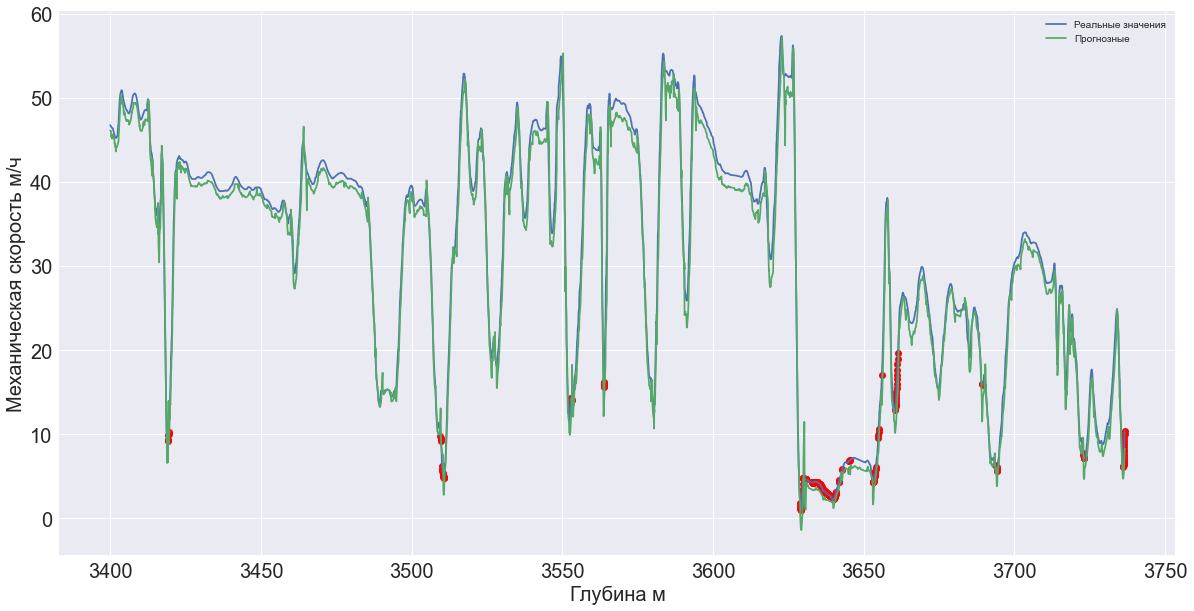

In [804]:
def plot_anomaly(data):
    fig,ax = plt.subplots(1,1,figsize=(20,10))
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20) 
    anomaly = np.array(data['Anomaly'].values)
    ROP = np.array(data['Реальные значения'].values)
    depth = np.array(data['Глубина'].values)
    plt.xlabel('Глубина м', fontsize=20)
    plt.ylabel('Механическая скорость м/ч', fontsize=20)
    plt.tick_params(axis='both',labelsize=20)
    for i in range(len(anomaly)):
        if anomaly[i] == 1:
            plt.plot(depth[i],ROP[i],marker='o',color='red')
    plt.plot(depth,data['Реальные значения'],label = 'Реальные значения')
    plt.plot(depth,data['Прогнозные'],label = 'Прогнозные')
    plt.grid(True)
    plt.legend()
    
plot_anomaly(data.loc[(data['Глубина'] > 3400) & (data['Глубина'] < 3800)])

# Моделирование забития колонны

In [805]:
# моделирование аварий
test = pd.read_csv('USROP_A 5 N-SH-F-5d.csv')


test = data_preproccesing(test)  

 1    17067
-1     1481
Name: anomaly, dtype: int64


In [806]:
test_anom = test.loc[(test['Measured Depth m'] > 3400) & (test['Measured Depth m'] < 3800)]

In [807]:
test_anom_sm = data_smoothing(test_anom)

<ipython-input-10-e442db16f5d4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Rate of Penetration m/h'] = savgol_filter(data['Rate of Penetration m/h'].values,89,3)
<ipython-input-10-e442db16f5d4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Average Hookload kkgf'] = savgol_filter(data['Average Hookload kkgf'].values,101,3)
<ipython-input-10-e442db16f5d4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [808]:
test_anom_sm = test_anom_sm.reset_index(drop=True)

In [809]:
test_anom_sm.loc[(test_anom_sm['Measured Depth m'] > 3465) &(test_anom_sm['Measured Depth m'] < 3470)]

,Unnamed: 0,Measured Depth m,Weight on Bit kkgf,Average Standpipe Pressure kPa,Average Surface Torque kN.m,Rate of Penetration m/h,Average Rotary Speed rpm,Mud Flow In L/min,Mud Density In g/cm3,Diameter mm,Average Hookload kkgf,Hole Depth (TVD) m,USROP Gamma gAPI
1395,11284,3465.03,3.37,21220.14,26.86,44.21,180.01,2089.36,1.46,215.90,144.09,3049.69,41.10
1396,11285,3465.10,3.39,21219.34,26.91,44.42,180.00,2089.36,1.46,215.90,144.07,3049.74,41.04
1397,11286,3465.12,3.40,21218.48,26.95,44.61,180.00,2089.36,1.46,215.90,144.06,3049.75,41.03
1398,11287,3465.16,3.42,21217.87,26.99,44.80,180.00,2089.36,1.46,215.90,144.04,3049.78,41.05
1399,11288,3465.22,3.43,21217.16,27.03,44.97,179.99,2089.36,1.46,215.90,144.02,3049.82,41.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,11366,3469.84,3.44,21215.40,26.94,47.31,179.93,2089.40,1.46,215.90,144.02,3052.97,73.85
1478,11367,3469.84,3.45,21216.09,26.93,47.28,179.93,2089.40,1.46,215.90,144.01,3052.98,73.46
1479,11368,3469.96,3.46,21216.77,26.93,47.25,179.93,2089.40,1.46,215.90,144.00,3053.06,73.08
1480,11369,3470.00,3.47,21217.45,26.92,47.22,179.92,2089.40,1.46,215.90,143.99,3053.08,72.64


In [25]:
random.seed()
def randval(c,center,noise):
    return random.random()*noise+center
rand2 = functools.partial(randval, center=500000, noise=200000)


In [811]:
# Моделирование осложнения

rand2 = functools.partial(randval, center=500000, noise=200000)
test_anom_sm['Average Standpipe Pressure kPa'][1395:1450] = np.array(list(map(rand2,test_anom_sm['Average Standpipe Pressure kPa'][1395:1450])))

rand2 = functools.partial(randval, center=10, noise=1)
test_anom_sm['Rate of Penetration m/h'][1395:1450] = np.array(list(map(rand2,test_anom_sm['Rate of Penetration m/h'][1395:1450])))


rand2 = functools.partial(randval, center=1500, noise=200)
test_anom_sm['Mud Flow In L/min'][1395:1420] = np.array(list(map(rand2,test_anom_sm['Mud Flow In L/min'][1395:1420])))

rand2 = functools.partial(randval, center=500, noise=100)
test_anom_sm['Mud Flow In L/min'][1420:1450] = np.array(list(map(rand2,test_anom_sm['Mud Flow In L/min'][1420:1450])))


<ipython-input-811-1d8850863d29>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_anom_sm['Average Standpipe Pressure kPa'][1395:1450] = np.array(list(map(rand2,test_anom_sm['Average Standpipe Pressure kPa'][1395:1450])))
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-811-1d8850863d29>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

In [813]:
# прогнозирование осложнения
x_test,y_test,scaler_x,scaler_y = test_preprocces_for_LSTM(test_anom_sm)

with tf.device(tf.DeviceSpec(device_type="CPU")):
    prediction = model.predict(x_test)
    
predictions = scaler_y.inverse_transform(prediction)

X_train shape == (8587, 50, 12).
y_train shape == (8587, 1, 1).


In [818]:
b = predictions[:,]
a = np.array(test_anom_sm['Rate of Penetration m/h'][59:,].values)

data = pd.DataFrame(data=a,columns=['Реальные значения'])
data['Прогнозные'] = b[:,]
data['Глубина'] = test_anom_sm.loc[(test_anom_sm['Measured Depth m'] < 3500)]['Measured Depth m']


anom_detect = detect_classify_anomalies(data,20)

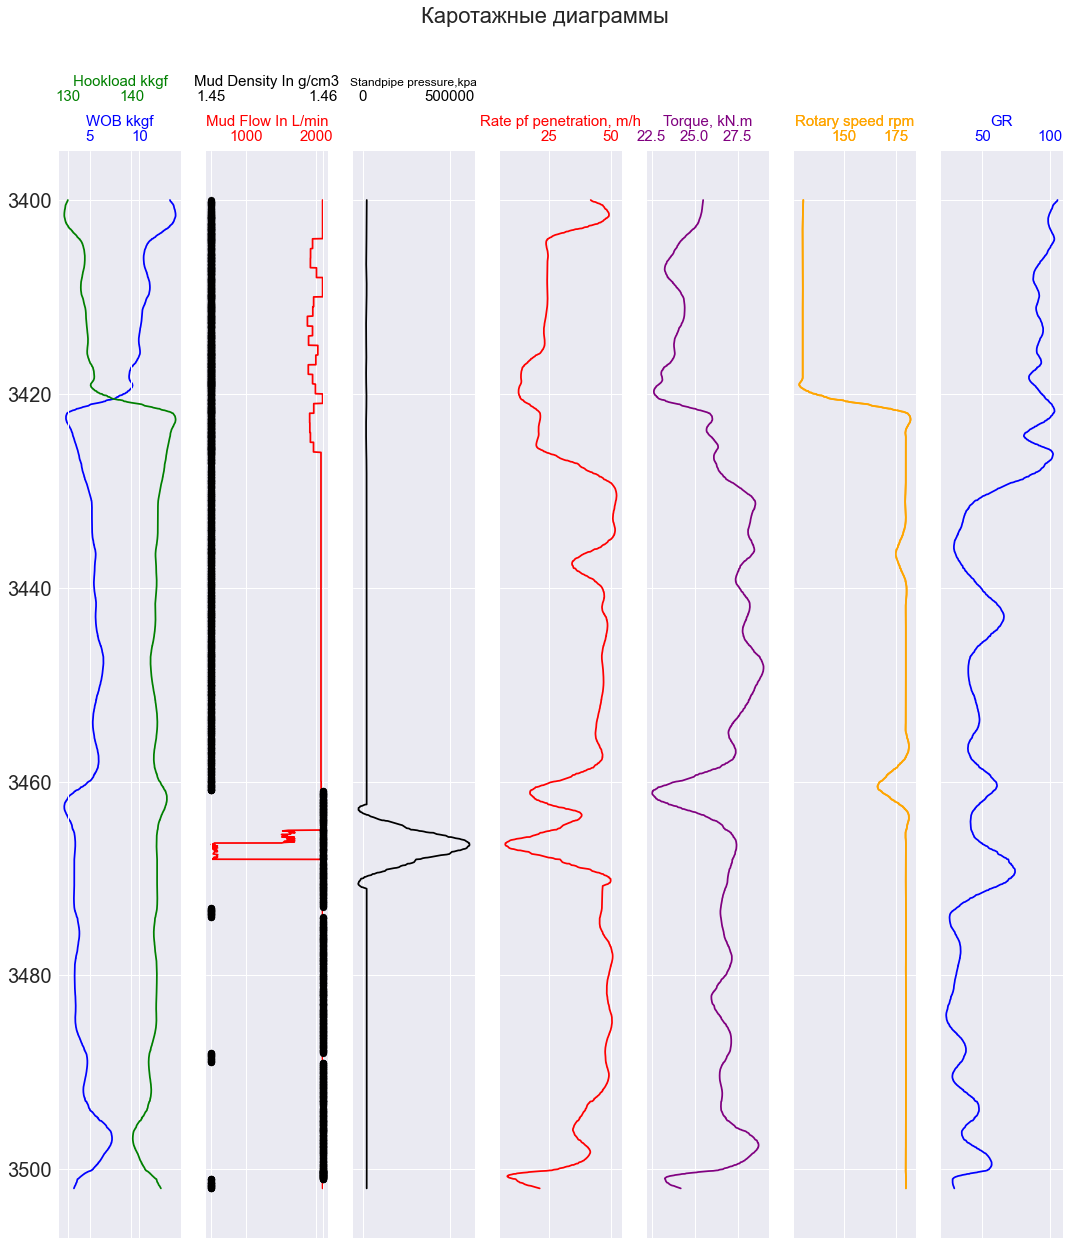

In [819]:
functions.log_plot(test_anom_sm.loc[(test_anom_sm['Measured Depth m'] < 3502)])

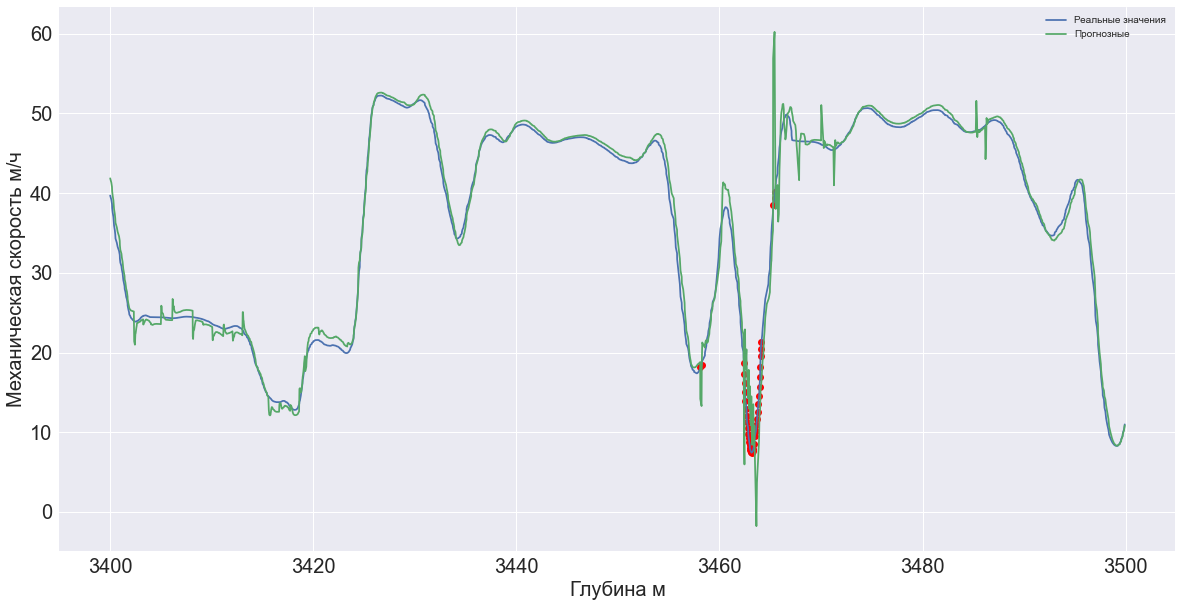

In [820]:
plot_anomaly(anom_detect)

## Моделирование ГНВП

In [19]:
# моделирование аварий
test = pd.read_csv('USROP_A 5 N-SH-F-5d.csv')


test = data_preproccesing(test)  

 1    17067
-1     1481
Name: anomaly, dtype: int64


In [20]:
#model = keras.models.load_model('LSTMpred2.h5')

In [21]:
test_anom = test.loc[(test['Measured Depth m'] > 3300) & (test['Measured Depth m'] < 3400)]
test_anom_sm = data_smoothing(test_anom)
test_anom_sm = test_anom_sm.reset_index(drop=True)

<ipython-input-9-e442db16f5d4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Rate of Penetration m/h'] = savgol_filter(data['Rate of Penetration m/h'].values,89,3)
<ipython-input-9-e442db16f5d4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Average Hookload kkgf'] = savgol_filter(data['Average Hookload kkgf'].values,101,3)
<ipython-input-9-e442db16f5d4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [22]:
test_anom_sm.loc[(test_anom_sm['Measured Depth m'] > 3350) &(test_anom_sm['Measured Depth m'] < 3360)]

,Unnamed: 0,Measured Depth m,Weight on Bit kkgf,Average Standpipe Pressure kPa,Average Surface Torque kN.m,Rate of Penetration m/h,Average Rotary Speed rpm,Mud Flow In L/min,Mud Density In g/cm3,Diameter mm,Average Hookload kkgf,Hole Depth (TVD) m,USROP Gamma gAPI
993,9024,3350.06,11.73,20764.12,23.78,45.33,129.96,2089.97,1.44,215.90,131.69,2963.06,131.98
994,9025,3350.21,11.71,20805.01,23.78,45.49,129.96,2089.97,1.44,215.90,131.67,2963.19,132.08
995,9026,3350.24,11.67,20843.89,23.79,45.65,129.97,2089.97,1.44,215.90,131.67,2963.21,132.16
996,9027,3350.31,11.64,20881.23,23.80,45.79,129.97,2089.97,1.44,215.90,131.67,2963.27,132.24
997,9028,3350.36,11.61,20916.94,23.81,45.93,129.97,2089.97,1.44,215.90,131.67,2963.31,132.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166,9197,3359.66,10.79,21127.31,23.15,37.98,129.96,2089.91,1.44,215.90,131.39,2970.98,124.33
1167,9198,3359.73,10.78,21127.64,23.12,37.81,129.96,2089.91,1.44,215.90,131.39,2971.04,124.38
1168,9199,3359.81,10.77,21127.97,23.08,37.64,129.95,2089.91,1.44,215.90,131.40,2971.10,124.46
1169,9200,3359.96,10.77,21128.29,23.05,37.48,129.95,2089.91,1.44,215.90,131.41,2971.23,124.72


In [23]:
test_anom_sm.loc[(test_anom_sm['Measured Depth m'] > 3357) &(test_anom_sm['Measured Depth m'] < 3360)]

,Unnamed: 0,Measured Depth m,Weight on Bit kkgf,Average Standpipe Pressure kPa,Average Surface Torque kN.m,Rate of Penetration m/h,Average Rotary Speed rpm,Mud Flow In L/min,Mud Density In g/cm3,Diameter mm,Average Hookload kkgf,Hole Depth (TVD) m,USROP Gamma gAPI
1115,9146,3357.07,10.71,21113.24,23.62,43.31,129.98,2090.01,1.44,215.90,131.47,2968.85,134.31
1116,9147,3357.08,10.71,21113.16,23.63,43.27,129.98,2090.01,1.44,215.90,131.47,2968.86,134.13
1117,9148,3357.14,10.71,21113.11,23.64,43.23,129.98,2090.01,1.44,215.90,131.47,2968.91,133.93
1118,9149,3357.20,10.71,21113.08,23.65,43.18,129.98,2090.01,1.44,215.90,131.47,2968.96,133.76
1119,9150,3357.22,10.71,21113.09,23.65,43.14,129.98,2090.01,1.44,215.90,131.47,2968.98,133.58
1120,9151,3357.26,10.71,21112.79,23.67,43.09,129.98,2090.01,1.44,215.90,131.47,2969.01,133.41
1121,9152,3357.34,10.71,21112.56,23.68,43.05,129.98,2090.01,1.44,215.90,131.47,2969.07,133.24
1122,9153,3357.37,10.71,21112.39,23.69,43.00,129.98,2090.01,1.44,215.90,131.47,2969.10,133.06
1123,9154,3357.39,10.71,21112.29,23.70,42.96,129.98,2090.01,1.44,215.90,131.46,2969.12,132.94
1124,9155,3357.45,10.71,21112.26,23.71,42.91,129.99,2090.01,1.44,215.90,131.46,2969.17,132.82


In [40]:
# Моделирование осложнения

rand2 = functools.partial(randval, center=1.1, noise=0.1)
test_anom_sm['Mud Density In g/cm3'][993:1115] = np.array(list(map(rand2,test_anom_sm['Mud Density In g/cm3'][993:1115])))

rand2 = functools.partial(randval, center=0.8, noise=0.1)
test_anom_sm['Mud Density In g/cm3'][1115:1170] = np.array(list(map(rand2,test_anom_sm['Mud Density In g/cm3'][1115:1170])))




rand2 = functools.partial(randval, center=100, noise=20)
test_anom_sm['Rate of Penetration m/h'][993:1115] = np.array(list(map(rand2,test_anom_sm['Rate of Penetration m/h'][993:1115])))

rand2 = functools.partial(randval, center=60, noise=20)
test_anom_sm['Rate of Penetration m/h'][1115:1170] = np.array(list(map(rand2,test_anom_sm['Rate of Penetration m/h'][1115:1170])))




rand2 = functools.partial(randval, center=100000, noise=100)
test_anom_sm['Mud Flow In L/min'][993:1115] = np.array(list(map(rand2,test_anom_sm['Mud Flow In L/min'][993:1115])))

rand2 = functools.partial(randval, center=5000, noise=200)
test_anom_sm['Mud Flow In L/min'][1115:1170] = np.array(list(map(rand2,test_anom_sm['Mud Flow In L/min'][1115:1170])))

rand2 = functools.partial(randval, center=140, noise=5)
test_anom_sm['Average Rotary Speed rpm'][993:1115] = np.array(list(map(rand2,test_anom_sm['Mud Flow In L/min'][993:1115])))

rand2 = functools.partial(randval, center=137, noise=7)
test_anom_sm['Average Rotary Speed rpm'][1115:1170] = np.array(list(map(rand2,test_anom_sm['Mud Flow In L/min'][1115:1170])))


rand2 = functools.partial(randval, center=40, noise=15)
test_anom_sm['Average Surface Torque kN.m'][993:1115] = np.array(list(map(rand2,test_anom_sm['Average Surface Torque kN.m'][993:1115])))

rand2 = functools.partial(randval, center=43, noise=12)
test_anom_sm['Average Surface Torque kN.m'][1115:1170] = np.array(list(map(rand2,test_anom_sm['Average Surface Torque kN.m'][1115:1170])))



<ipython-input-40-7fd5e792f415>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_anom_sm['Mud Density In g/cm3'][993:1115] = np.array(list(map(rand2,test_anom_sm['Mud Density In g/cm3'][993:1115])))
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-40-7fd5e792f415>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

In [ ]:
def test_preprocces_for_LSTM(data):
    test = data_smoothing(data)
    y_test = np.array(test['Rate of Penetration m/h'])
    test_1 = test.drop(['Unnamed: 0'],axis=1)
    x_test = np.array(test_1)
    x_test_sc,y_test_sc,scaler_x,scaler_y = data_encoding(x_test,y_test)
    x_test,y_test = transform_data_multiple_features(x_test_sc,y_test_sc,10,50)
    return x_test,y_test,scaler_x,scaler_y

In [ ]:
# прогнозирование осложнения
x_test,y_test,scaler_x,scaler_y = test_preprocces_for_LSTM(test_anom_sm)

with tf.device(tf.DeviceSpec(device_type="CPU")):
    prediction = model.predict(x_test)
    
predictions = scaler_y.inverse_transform(prediction)

In [ ]:
b = predictions[:,]
a = np.array(test_anom_sm['Rate of Penetration m/h'][59:,].values)

data = pd.DataFrame(data=a,columns=['Реальные значения'])
data['Прогнозные'] = b[:,]
data['Глубина'] = test_anom_sm.loc[(test_anom_sm['Measured Depth m'] < 3500)]['Measured Depth m']


anom_detect = detect_classify_anomalies(data,20)

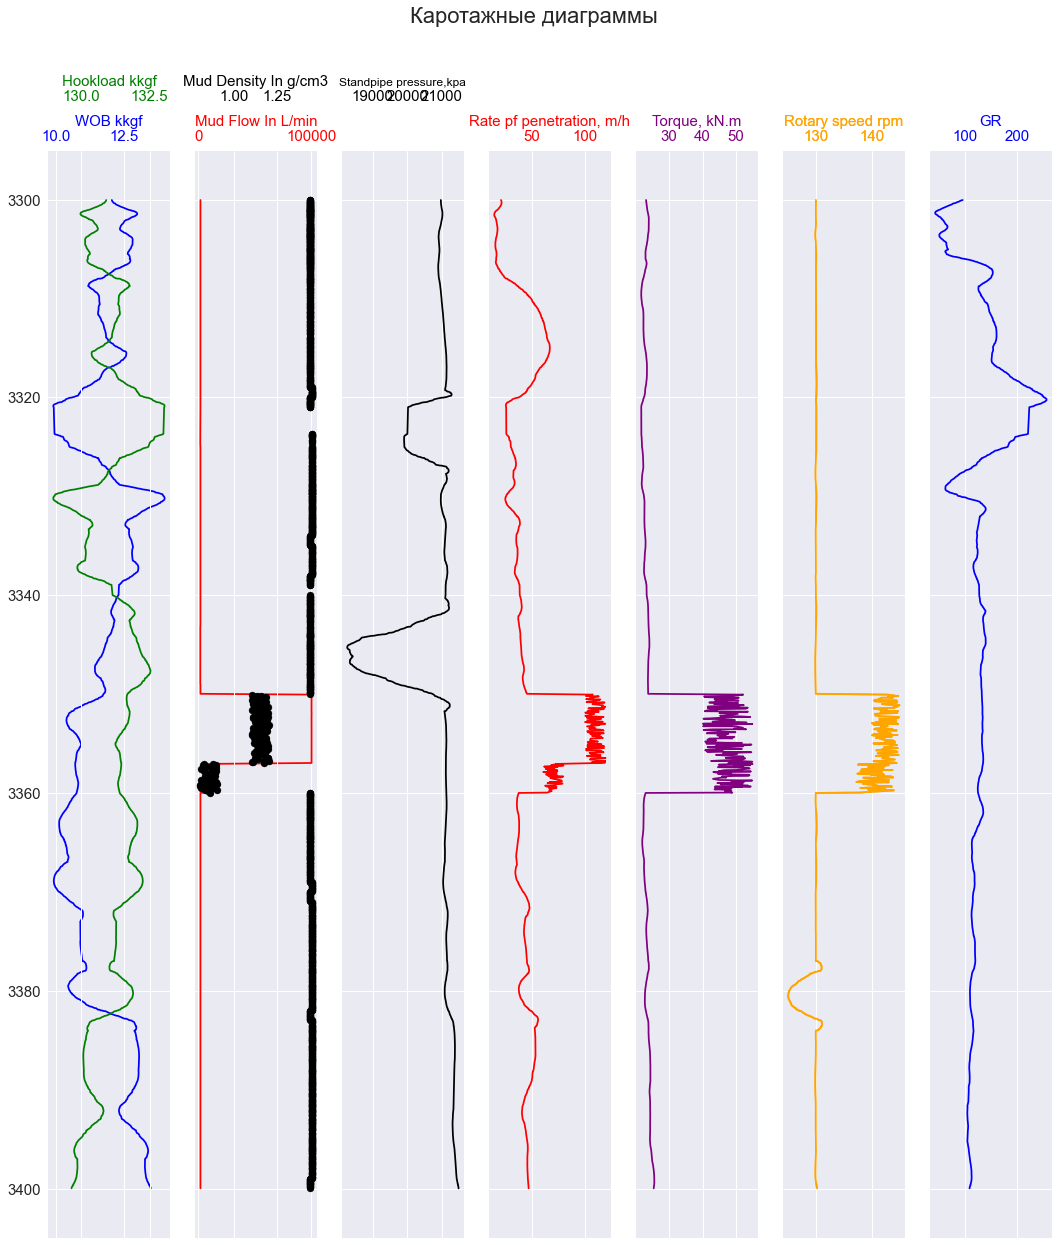

In [41]:
functions.log_plot(test_anom_sm.loc[(test_anom_sm['Measured Depth m'] < 3400)])

In [837]:
anom_detect

,Реальные значения,Прогнозные,Глубина,Delta,Anomaly
0,14.61,12.94,3300.05,11.46,1
1,14.58,12.89,3300.07,11.60,1
2,14.56,12.83,3300.09,11.89,1
3,14.54,12.77,3300.12,12.19,1
4,14.53,12.73,3300.18,12.40,1
...,...,...,...,...,...
1794,46.68,41.70,3396.25,10.68,1
1795,46.76,41.79,3396.32,10.64,1
1796,46.85,41.84,3396.38,10.70,1
1797,46.94,41.90,3396.39,10.73,1


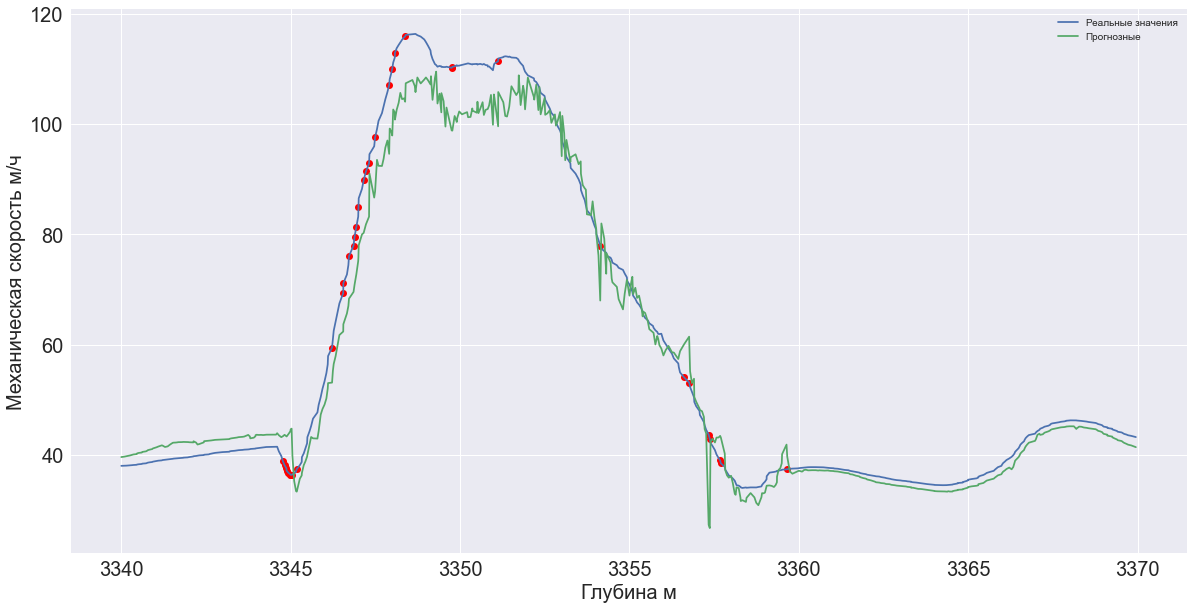

In [838]:
plot_anomaly(anom_detect.loc[(anom_detect['Глубина'] > 3340)  & (anom_detect['Глубина'] < 3370)])